# FBI Gun background checks and Census Bureau data study

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The following study is looking into two datasets. The first is the records of gunshops' background checks for each state in the USAfrom 1998 to 2017. Those are detailled into the types of transaction the checks has been performed for. The data is numeric and historical. The second dataset is a collection of social meatrics for each state. It represents various features of the American society on a given time (mostly year 2010 and year 2016).


### Questions to  answer

At the first glance, the question that immediately pops up is "How have guns sales evolved over time?".
Moreover, we will be investigating the relationship between incremental gun ownership (gun sales per capita) and social features to find interesting correlations.

In [1]:
!pip install jupyterthemes

Looking in indexes: https://artprod.dev.bloomberg.com/artifactory/api/pypi/pypi-repos/simple, https://artprod.dev.bloomberg.com/artifactory/api/pypi/bloomberg-pypi/simple


In [2]:
import pandas as pd
import numpy as np
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from jupyterthemes import jtplot
jtplot.style('monokai')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
gun_df = pd.read_excel('gun_data.xlsx')
census_df = pd.read_csv('US_census_data.csv', index_col=0).transpose()

# Exploration gun dataset

In [4]:
gun_df.head() 
#The number of checks per firearm type, state and month

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [5]:
gun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

In [6]:
type(gun_df.month[0])
#Need to convert it to int or date

str

In [7]:
gun_df.month.value_counts(sort=True).sample(5)
#We have consistent timely data

2016-07    55
1998-12    55
2007-07    55
2013-06    55
2009-03    55
Name: month, dtype: int64

In [8]:
print(gun_df.month.sort_values().head())
print(gun_df.month.sort_values().tail())

12484    1998-11
12453    1998-11
12452    1998-11
12451    1998-11
12450    1998-11
Name: month, dtype: object
31    2017-09
30    2017-09
29    2017-09
27    2017-09
0     2017-09
Name: month, dtype: object


It seems we have consistent data from 1998 to 2017

In [9]:
gun_df.isna().sum()

month                            0
state                            0
permit                          24
permit_recheck               11385
handgun                         20
long_gun                        19
other                         6985
multiple                         0
admin                           23
prepawn_handgun               1943
prepawn_long_gun              1945
prepawn_other                 7370
redemption_handgun            1940
redemption_long_gun           1941
redemption_other              7370
returned_handgun             10285
returned_long_gun            10340
returned_other               10670
rentals_handgun              11495
rentals_long_gun             11660
private_sale_handgun          9735
private_sale_long_gun         9735
private_sale_other            9735
return_to_seller_handgun     10010
return_to_seller_long_gun     9735
return_to_seller_other       10230
totals                           0
dtype: int64

The main columns have a limited amount of NaN values we will be able to fix. Although, for some other types of checks it seems we have to many NaN values to perform a meaningful study

In [10]:
gun_df.describe()

,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
count,12461.000000,1100.000000,12465.000000,12466.000000,5500.000000,12485.000000,12462.000000,10542.000000,10540.000000,5115.000000,...,1815.000000,990.000000,825.000000,2750.000000,2750.000000,2750.000000,2475.000000,2750.000000,2255.000000,12485.000000
mean,6413.629404,1165.956364,5940.881107,7810.847585,360.471636,268.603364,58.898090,4.828021,7.834156,0.165591,...,1.027548,0.076768,0.087273,14.936000,11.602909,1.030182,0.402020,0.441818,0.105987,21595.725911
std,23752.338269,9224.200609,8618.584060,9309.846140,1349.478273,783.185073,604.814818,10.907756,16.468028,1.057105,...,4.386296,0.634503,0.671649,71.216021,54.253090,4.467843,1.446568,1.528223,0.427363,32591.418387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,865.000000,2078.250000,17.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4638.000000
50%,518.000000,0.000000,3059.000000,5122.000000,121.000000,125.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12399.000000
75%,4272.000000,0.000000,7280.000000,10380.750000,354.000000,301.000000,0.000000,5.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,25453.000000
max,522188.000000,116681.000000,107224.000000,108058.000000,77929.000000,38907.000000,28083.000000,164.000000,269.000000,49.000000,...,64.000000,12.000000,12.000000,1017.000000,777.000000,71.000000,28.000000,17.000000,4.000000,541978.000000


It looks like the first main columns have some extreme values but are very concentrated around smallernumber since the 75% quartile thresholds are rather low 

In [11]:
gun_df['month'].nunique()

227

In [12]:
gun_df['state'].nunique()

55

In [13]:
gun_df.groupby('state').mean().sample(5)

,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
state,,,,,,,,,,,,,,,,,,,,,
West Virginia,436.202643,0.00,4405.374449,6652.911894,180.11,294.229075,1.462555,3.906250,9.625000,0.107527,...,1.121212,0.0,0.0,6.20,4.82,0.26,0.222222,0.32,0.097561,14136.074890
Ohio,1640.004405,166.15,16702.453744,16063.105727,1053.27,789.052863,0.136564,12.895833,39.442708,0.806452,...,0.969697,0.0,0.0,13.40,7.32,0.62,0.866667,0.44,0.195122,37280.810573
Idaho,1626.519824,3.00,2078.572687,3883.026432,118.17,140.418502,99.356828,2.541667,6.026042,0.150538,...,0.393939,0.0,0.0,2.06,3.52,0.20,0.222222,0.48,0.073171,8670.193833
Montana,639.374449,0.30,2056.629956,4225.515419,93.40,169.044053,5.566372,2.437500,8.895833,0.774194,...,1.151515,0.0,0.0,1.80,2.42,0.22,0.422222,0.68,0.073171,8300.105727
Georgia,7870.960352,0.00,9373.466960,10080.995595,286.92,389.409692,1819.013216,11.901042,18.088542,0.279570,...,0.000000,0.0,0.0,5.66,3.60,0.44,0.244444,0.36,0.048780,31761.859031


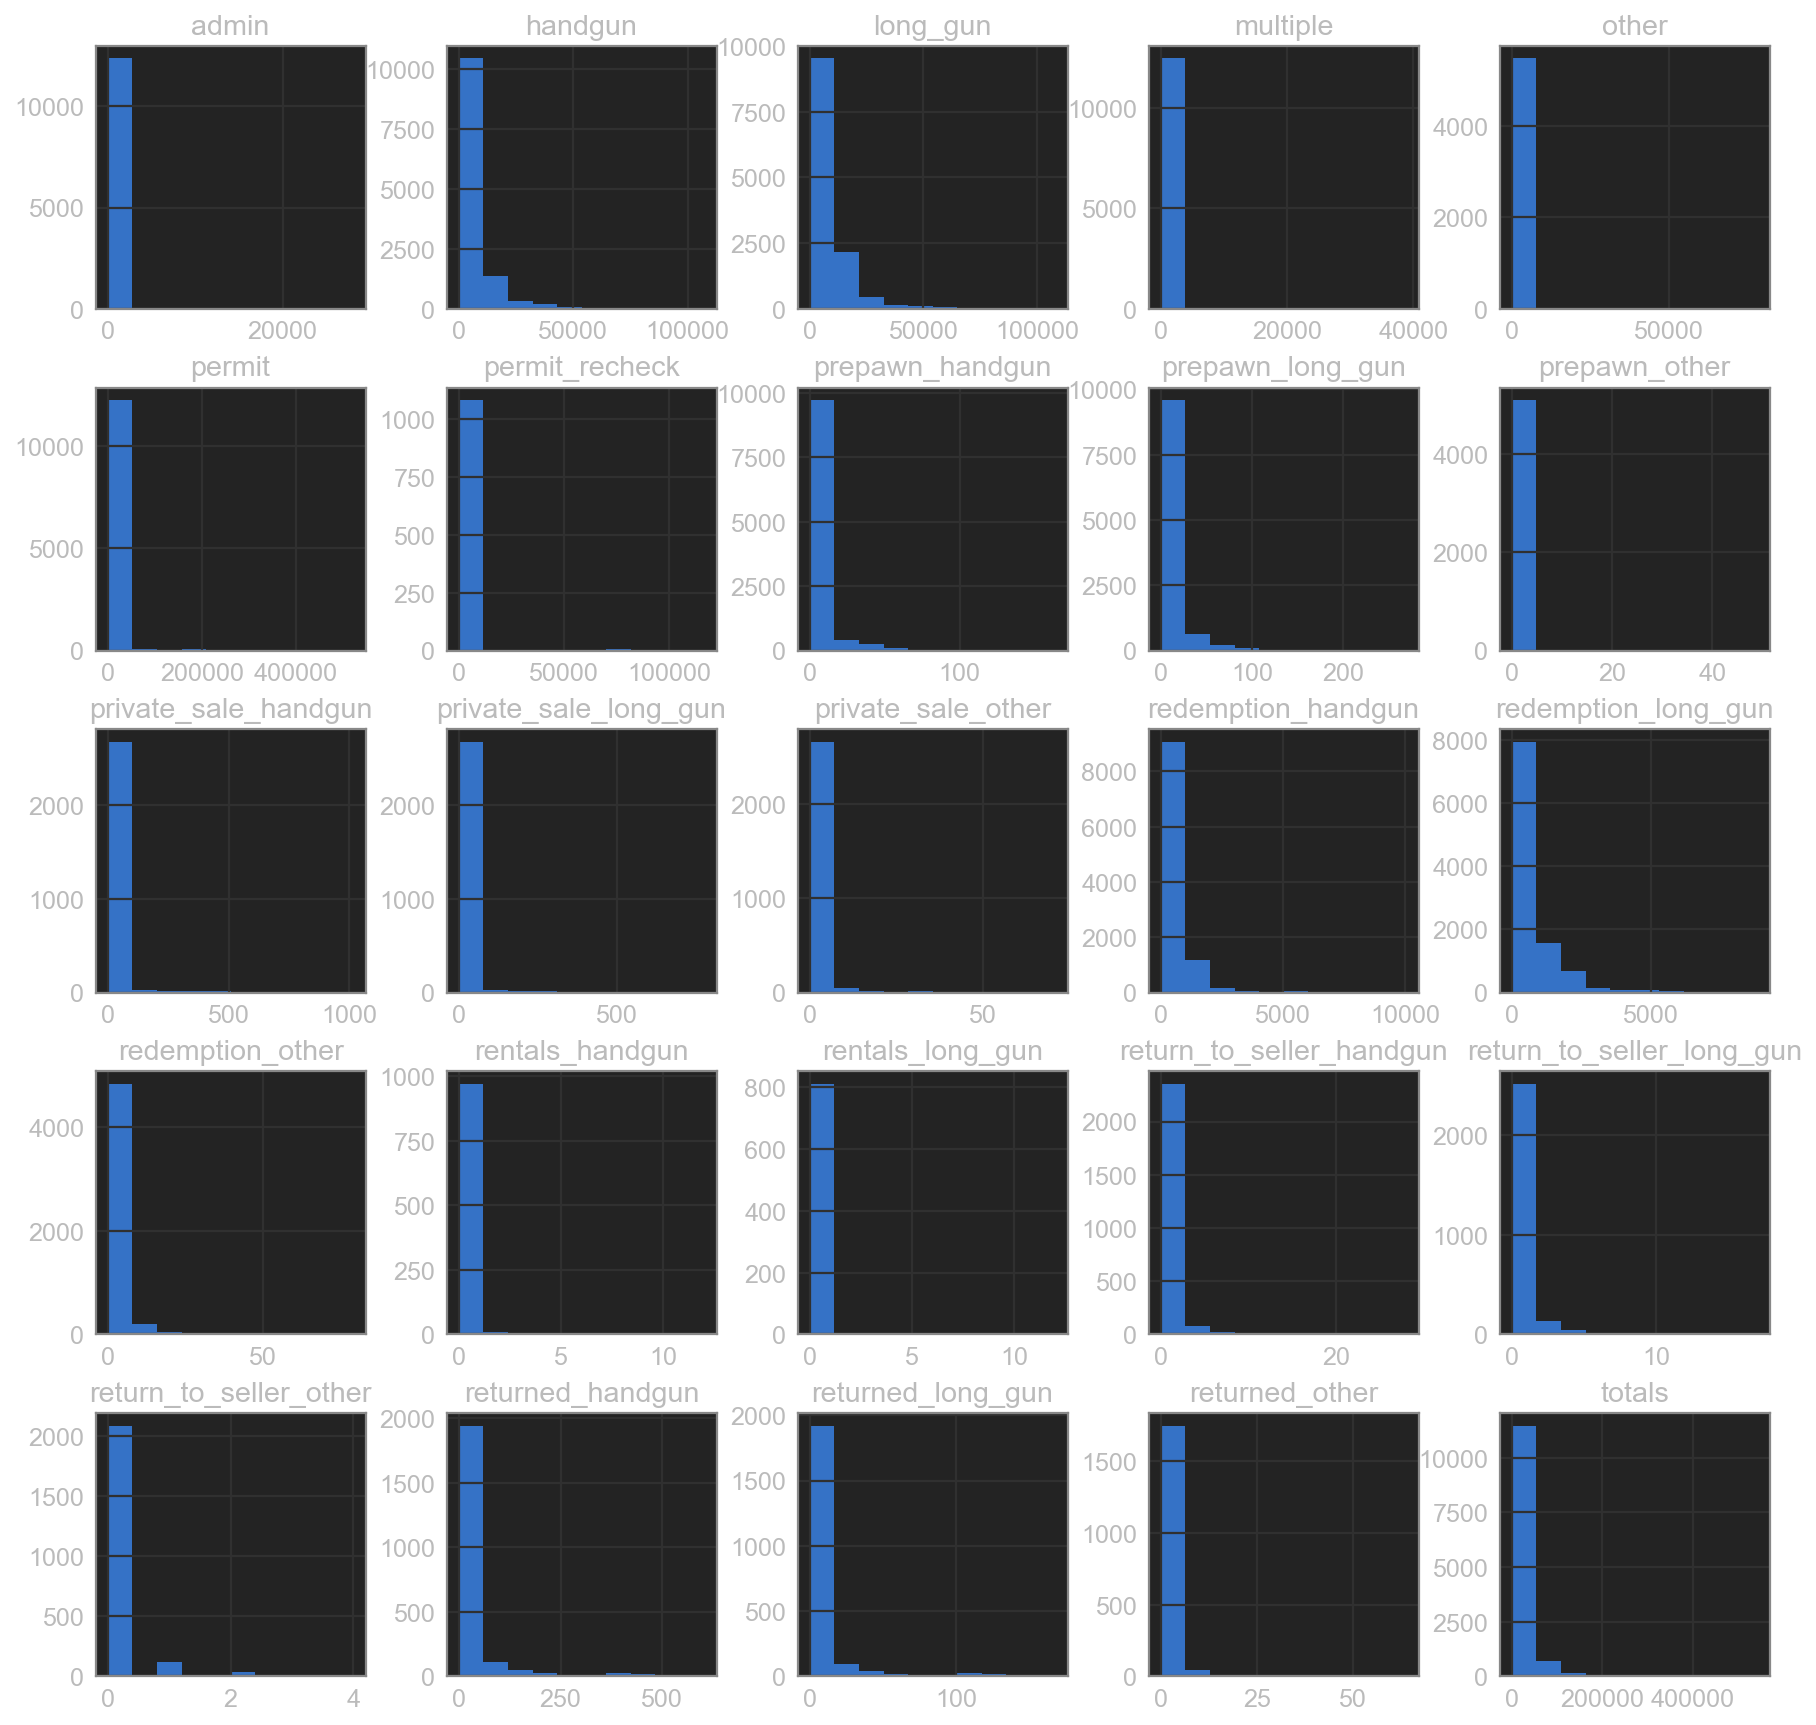

In [14]:
gun_df.hist(figsize=(15,15));

Distributions of variables are highly concentrated on the left and don't seem very skewed on the right

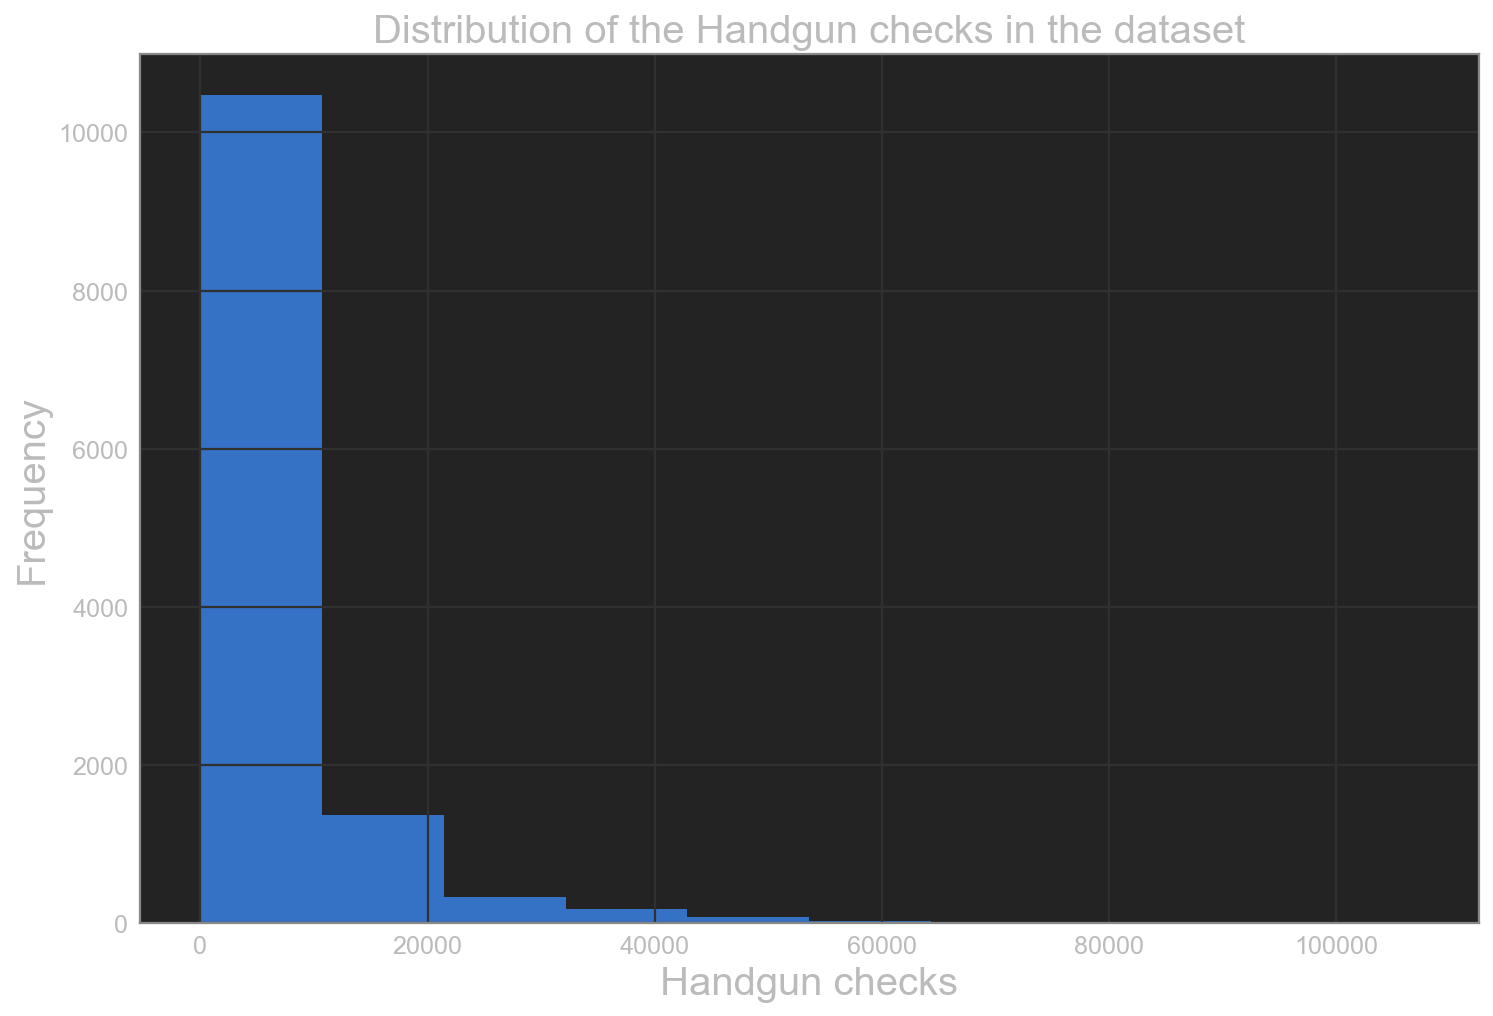

In [68]:
gun_df['handgun'].hist(figsize=(12, 8))
plt.xlabel('Handgun checks', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of the Handgun checks in the dataset', fontsize=20);

# Exploration Census dataset

In [16]:
census_df.head(5)

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,nan,Value Flags,-,D,F,FN,nan,S,X,Z
Fact Note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Either no or too few sample observations were ...,Suppressed to avoid disclosure of confidential...,Fewer than 25 firms,Footnote on this item in place of data,Not available,Suppressed; does not meet publication standards,Not applicable,Value greater than zero but less than half uni...
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arkansas,"2,988,248","2,916,025",2.50%,"2,915,918",6.40%,6.80%,23.60%,24.40%,16.30%,14.40%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The census dataset is not historical. Therefore we will have to use point-in-time information and group the gun dataframe to investigate correlations.
Let's keep in mind that the top line is unnecessary and should be removed.

In [17]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Fact Note to Wyoming
Data columns (total 85 columns):
Population estimates, July 1, 2016,  (V2016)                                              50 non-null object
Population estimates base, April 1, 2010,  (V2016)                                        50 non-null object
Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)     50 non-null object
Population, Census, April 1, 2010                                                         50 non-null object
Persons under 5 years, percent, July 1, 2016,  (V2016)                                    50 non-null object
Persons under 5 years, percent, April 1, 2010                                             50 non-null object
Persons under 18 years, percent, July 1, 2016,  (V2016)                                   50 non-null object
Persons under 18 years, percent, April 1, 2010                                            50 non-null object
Persons 65 years 

The object type will be problematic if we want to perform calculations on this dataset 
The labels are long names and not easy to manipulate, will need to select those we are interested in and rename them

In [18]:
type(census_df['Population estimates, July 1, 2016,  (V2016)'][0])

float

The population, that we identify as one of the most important metric for the study, is a float type and will be easy to  manipulate to perform calculation 

In [19]:
census_df.iloc[:,0]

Fact Note                NaN
Alabama            4,863,300
Alaska               741,894
Arizona            6,931,071
Arkansas           2,988,248
California        39,250,017
Colorado           5,540,545
Connecticut        3,576,452
Delaware             952,065
Florida           20,612,439
Georgia           10,310,371
Hawaii             1,428,557
Idaho              1,683,140
Illinois          12,801,539
Indiana            6,633,053
Iowa               3,134,693
Kansas             2,907,289
Kentucky           4,436,974
Louisiana          4,681,666
Maine              1,331,479
Maryland           6,016,447
Massachusetts      6,811,779
Michigan           9,928,300
Minnesota          5,519,952
Mississippi        2,988,726
Missouri           6,093,000
Montana            1,042,520
Nebraska           1,907,116
Nevada             2,940,058
New Hampshire      1,334,795
New Jersey         8,944,469
New Mexico           2081015
New York            19745289
North Carolina      10146788
North Dakota  

In [20]:
census_df.describe()

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,nan,Value Flags,-,D,F,FN,nan,S,X,Z
count,50,50,50,50,50,50,50,50,50,50,...,0.0,0.0,1,1,1,1,1,1,1,1
unique,50,50,45,50,29,29,43,40,39,40,...,0.0,0.0,1,1,1,1,1,1,1,1
top,"2,907,289","6,392,301",1.70%,3831074,6.40%,7.10%,22.80%,24.40%,16.10%,13.80%,...,NaN,NaN,Either no or too few sample observations were ...,Suppressed to avoid disclosure of confidential...,Fewer than 25 firms,Footnote on this item in place of data,Not available,Suppressed; does not meet publication standards,Not applicable,Value greater than zero but less than half uni...
freq,1,1,3,1,6,4,3,3,4,4,...,NaN,NaN,1,1,1,1,1,1,1,1


In [21]:
census_df.isna().sum()

Fact
Population estimates, July 1, 2016,  (V2016)                                              1
Population estimates base, April 1, 2010,  (V2016)                                        1
Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)     1
Population, Census, April 1, 2010                                                         1
Persons under 5 years, percent, July 1, 2016,  (V2016)                                    1
Persons under 5 years, percent, April 1, 2010                                             1
Persons under 18 years, percent, July 1, 2016,  (V2016)                                   1
Persons under 18 years, percent, April 1, 2010                                            1
Persons 65 years and over, percent,  July 1, 2016,  (V2016)                               1
Persons 65 years and over, percent, April 1, 2010                                         1
Female persons, percent,  July 1, 2016,  (V2016)                           

Despite the fact that the dataframe is short, the data looks consistent with almost no NaN values

Let's check consistency in terms of keys to be able to connect the two dataframes later on. Let's have a look at the number of states used:

In [22]:
census_states = census_df.index
gun_states = gun_df.state.unique()

print(len(census_states) - 1) #Beware the 'Fact note' top line
print(len(gun_states))

50
55


There is a discrepency within the states between the two datasets. Let's find out what is the difference:

In [23]:
print(np.setdiff1d(gun_states, census_states))

['District of Columbia' 'Guam' 'Mariana Islands' 'Puerto Rico'
 'Virgin Islands']


It looks fine, the discrepency comes from the 'special' territories. The 50 main states are the same in both datasets

https://www.worldatlas.com/articles/how-many-states-are-there-in-the-united-states.html

<a id='wrangling'></a>
## Data Wrangling



### Gun Dataframe

From GitHub:
    'These statistics represent the number of firearm background checks initiated through the NICS They do not represent the number of firearms sold Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale'

Let's arrange types first to be able to plot later on. We want to  make sure that numerical values are float and date type is right:

In [24]:
gun_df['multiple'] = gun_df['multiple'].astype(float)
gun_df['totals'] = gun_df['totals'].astype(float)

gun_df.month = gun_df.month.astype('datetime64[ns]')
type(gun_df.month[0])

pandas._libs.tslibs.timestamps.Timestamp

As per the preliminary investiagtion of the data, we are now going to fill the NaN values:

In [25]:
#filing NaN values
gun_df.sort_values('state')
gun_df['handgun'].fillna(method='ffill', inplace=True)
gun_df['long_gun'].fillna(method='ffill', inplace=True)
gun_df.isna().sum()

month                            0
state                            0
permit                          24
permit_recheck               11385
handgun                          0
long_gun                         0
other                         6985
multiple                         0
admin                           23
prepawn_handgun               1943
prepawn_long_gun              1945
prepawn_other                 7370
redemption_handgun            1940
redemption_long_gun           1941
redemption_other              7370
returned_handgun             10285
returned_long_gun            10340
returned_other               10670
rentals_handgun              11495
rentals_long_gun             11660
private_sale_handgun          9735
private_sale_long_gun         9735
private_sale_other            9735
return_to_seller_handgun     10010
return_to_seller_long_gun     9735
return_to_seller_other       10230
totals                           0
dtype: int64

Following the recommendation of the NYT authors,we only need a few columns to perform calculation on the number of gun sales
https://github.com/nytimes/gunsales#getting-gun-sales-estimates-from-background-checks

>To convert background checks into estimated sales, we relied on a method suggested in the Small Arms Survey by Jurgen Brauer, a professor at Georgia Regents University. Each long gun and handgun check was counted as 1.1 sales. Each multiple-gun check was counted as two sales. Permit checks and other types of checks were omitted. The multiplier is an estimate based on Mr. Brauer's interviews with gun shop owners.

Let's drop the columns not used for our study:

In [26]:
cols = list(gun_df.columns[8:])
cols = cols + ['permit_recheck', 'other', 'permit']
gun_df_clean = gun_df.drop(columns=cols, axis=1)

Let's have a look at what the data now looks like:

In [27]:
gun_df_clean.groupby(['state', 'month']).mean().sample(5)

,,handgun,long_gun,multiple
state,month,,,
Washington,2002-03-01,3688.0,5802.0,284.0
Puerto Rico,2004-08-01,472.0,124.0,19.0
Hawaii,2015-10-01,0.0,0.0,0.0
Vermont,1999-07-01,441.0,865.0,14.0
Hawaii,2014-08-01,0.0,0.0,0.0


### Census Dataframe

In [28]:
census_df.info()

#SOme measures are the same in 2010 and 2016 => do the %variation to find out of it evolved compared to guns sales

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Fact Note to Wyoming
Data columns (total 85 columns):
Population estimates, July 1, 2016,  (V2016)                                              50 non-null object
Population estimates base, April 1, 2010,  (V2016)                                        50 non-null object
Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)     50 non-null object
Population, Census, April 1, 2010                                                         50 non-null object
Persons under 5 years, percent, July 1, 2016,  (V2016)                                    50 non-null object
Persons under 5 years, percent, April 1, 2010                                             50 non-null object
Persons under 18 years, percent, July 1, 2016,  (V2016)                                   50 non-null object
Persons under 18 years, percent, April 1, 2010                                            50 non-null object
Persons 65 years 

In [29]:
census_df.rename(columns={'fact':'state'}, inplace=True)

In [30]:
census_df.drop(labels='Fact Note').head()

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,nan,Value Flags,-,D,F,FN,nan,S,X,Z
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arkansas,"2,988,248","2,916,025",2.50%,"2,915,918",6.40%,6.80%,23.60%,24.40%,16.30%,14.40%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
California,"39,250,017","37,254,522",5.40%,"37,253,956",6.30%,6.80%,23.20%,25.00%,13.60%,11.40%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's select only the metrics (columns) we are plannning on investigating later on:

In [31]:
#Manual selection, easy to customize
census_measures = ['Population estimates, July 1, 2016,  (V2016)',
                   'Persons 65 years and over, percent,  July 1, 2016,  (V2016)',
                   'Female persons, percent,  July 1, 2016,  (V2016)',
                   'Black or African American alone, percent, July 1, 2016,  (V2016)',
                   'Two or More Races, percent, July 1, 2016,  (V2016)',
                   'Veterans, 2011-2015',
                   'Median gross rent, 2011-2015',
                   'Persons per household, 2011-2015',
                   "Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015",
                   'With a disability, under age 65 years, percent, 2011-2015',
                   'Persons in poverty, percent',
                   'Total employment, 2015']

column_name = ['pop_16',
              'pop_over_65',
              'female_pop',
              'black_pop',
              'two_more_race',
              'vet',
              'med_rent',
              'per_houshold',
              'edu',
              'disabled',
              'poverty',
              'employment']

social_df = census_df[census_measures]
social_df.columns = column_name
social_df.drop(['Fact Note'], inplace=True)
print(social_df.columns)
print('\n')
social_df.sample(5)

Index(['pop_16', 'pop_over_65', 'female_pop', 'black_pop', 'two_more_race',
       'vet', 'med_rent', 'per_houshold', 'edu', 'disabled', 'poverty',
       'employment'],
      dtype='object')




C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment
Nevada,"2,940,058",15.00%,49.90%,9.60%,4.20%,"220,332",$973,2.72,23.00%,9.00%,13.80%,"1,129,965"
Delaware,"952,065",17.50%,51.60%,22.60%,2.60%,"71,213","$1,018",2.62,30.00%,8.50%,11.70%,"397,385"
Hawaii,"1,428,557",17.10%,49.80%,2.20%,23.70%,"110,238","$1,438",3.02,30.80%,6.50%,9.30%,"523,677"
Montana,"1,042,520",17.70%,49.70%,0.60%,2.70%,"90,000",$711,2.41,29.50%,9.10%,13.30%,"375,041"
New Mexico,2081015,0.165,0.505,0.025,0.025,164157,777,2.67,0.263,0.101,0.198,626284


Let's remember that Employment is a total number of employed people. To make it comparable we will need to calculate employment rate by dividing it with  the population in 2016

### Data Cleaning

As per the method suggested in the Small Arms Survey by Jurgen Brauer, a professor at Georgia Regents University, we will define a function to calculate the total guns sales with  the following inputs:

Each long gun and handgun check was counted as 1.1 sales. 
Each multiple-gun check was counted as two sales. Permit checks and other types of checks were omitted. 
The multiplier is an estimate based on Mr. Brauer's interviews with gun shop owners'

In [32]:
def sales_average(row):
    try:
    
        sales = (row['handgun'] * 1.1) + (row['long_gun'] * 1.1) + (row['multiple'] * 2)
                     
        return sales
    except ZeroDivisionError:
        return None

def sales_per_capita(row):
    try:
    
        sales_pc = (row['total_sales'] / row['pop_16']) * 100
                     
        return sales_pc
    except ZeroDivisionError:
        return None

def employment_rate(row):
    try:
    
        empl = (row['employment'] / row['pop_16']) * 100
                     
        return empl
    except ZeroDivisionError:
        return None

pattern = r'[,|$|%]'
def cleaning(st):
    
    rex = re.sub(pattern, '', str(st))
    
    return rex

Please note that I decided to locate all the function I will be using in the above cell to make it easier to refer to it.

For the application of the regular expression to an entire dataframe I have used the following stackoverflow topic:
https://stackoverflow.com/questions/53962844/applying-regex-across-entire-column-of-a-dataframe

In [33]:
social_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 12 columns):
pop_16           50 non-null object
pop_over_65      50 non-null object
female_pop       50 non-null object
black_pop        50 non-null object
two_more_race    50 non-null object
vet              50 non-null object
med_rent         50 non-null object
per_houshold     50 non-null object
edu              50 non-null object
disabled         50 non-null object
poverty          50 non-null object
employment       50 non-null object
dtypes: object(12)
memory usage: 5.1+ KB


In [34]:
type(social_df.female_pop[0])

str

It looks like the metrics data have been transformed in string type in the process. The symbols such as "$" or "," will be problematic to therefore apply mathematical operations.
Let's apply some cleaning thanks to functions I have defined above.
The regular expression is looking into columns' strings to remove special characteres before converting the data to float data type.

In [35]:
for column in social_df:
    if column == 'state':
        pass
    else:
        social_df[column] = social_df[column].apply(cleaning)
        social_df[column] = social_df[column].astype(float)

social_df.info()

C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 12 columns):
pop_16           50 non-null float64
pop_over_65      50 non-null float64
female_pop       50 non-null float64
black_pop        50 non-null float64
two_more_race    50 non-null float64
vet              50 non-null float64
med_rent         50 non-null float64
per_houshold     50 non-null float64
edu              50 non-null float64
disabled         50 non-null float64
poverty          50 non-null float64
employment       50 non-null float64
dtypes: float64(12)
memory usage: 7.6+ KB


We have now a dataframe made of float data we will be able to manipulate easily:

In [36]:
social_df.sample(5)

,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment
West Virginia,1831102.0,18.800,50.500,3.600,1.700,150021.0,643.0,2.43,19.200,14.400,17.900,565435.0
Texas,27862596.0,12.000,50.400,12.600,1.900,1539655.0,882.0,2.84,27.600,8.100,15.600,10239710.0
New York,19745289.0,0.154,0.514,0.177,0.025,828586.0,1132.0,2.63,0.342,0.074,0.147,7998994.0
Florida,20612439.0,19.900,51.100,16.800,2.100,1507738.0,1002.0,2.63,27.300,8.500,14.700,7777990.0
Virginia,8411808.0,14.600,50.800,19.800,2.900,706539.0,1116.0,2.62,36.300,7.700,11.000,3198718.0


<a id='eda'></a>
## Exploratory Data Analysis



### Research Question 1: How have gun sales evolved in the USA and in a sample of states from 1998 to nowadays

In [37]:
gun_df_clean.columns

Index(['month', 'state', 'handgun', 'long_gun', 'multiple'], dtype='object')

In [38]:
gun_df_clean.head(5)

,month,state,handgun,long_gun,multiple
0,2017-09-01,Alabama,5734.0,6320.0,317.0
1,2017-09-01,Alaska,2320.0,2930.0,160.0
2,2017-09-01,Arizona,11063.0,7946.0,631.0
3,2017-09-01,Arkansas,4347.0,6063.0,366.0
4,2017-09-01,California,37165.0,24581.0,0.0


First, let's apply the definition created above to calculate the total gun sales per sate and per  month:

In [39]:
gun_df_clean['total_sales'] = gun_df.apply(sales_average, axis=1)

In [40]:
gun_df_clean.head(5)

,month,state,handgun,long_gun,multiple,total_sales
0,2017-09-01,Alabama,5734.0,6320.0,317.0,13893.4
1,2017-09-01,Alaska,2320.0,2930.0,160.0,6095.0
2,2017-09-01,Arizona,11063.0,7946.0,631.0,22171.9
3,2017-09-01,Arkansas,4347.0,6063.0,366.0,12183.0
4,2017-09-01,California,37165.0,24581.0,0.0,67920.6


To be able to plot the total sales we need to group the dataframe by month and calculate the rolling average to remove the seasonality effect: 

In [41]:
grouped_gun_df = gun_df_clean.groupby('month').sum()
grouped_gun_df = grouped_gun_df.rolling(12).mean()
grouped_gun_df.head(13)

,handgun,long_gun,multiple,total_sales
month,,,,
1998-11-01,NaN,NaN,NaN,NaN
1998-12-01,NaN,NaN,NaN,NaN
1999-01-01,NaN,NaN,NaN,NaN
1999-02-01,NaN,NaN,NaN,NaN
1999-03-01,NaN,NaN,NaN,NaN
1999-04-01,NaN,NaN,NaN,NaN
1999-05-01,NaN,NaN,NaN,NaN
1999-06-01,NaN,NaN,NaN,NaN
1999-07-01,NaN,NaN,NaN,NaN


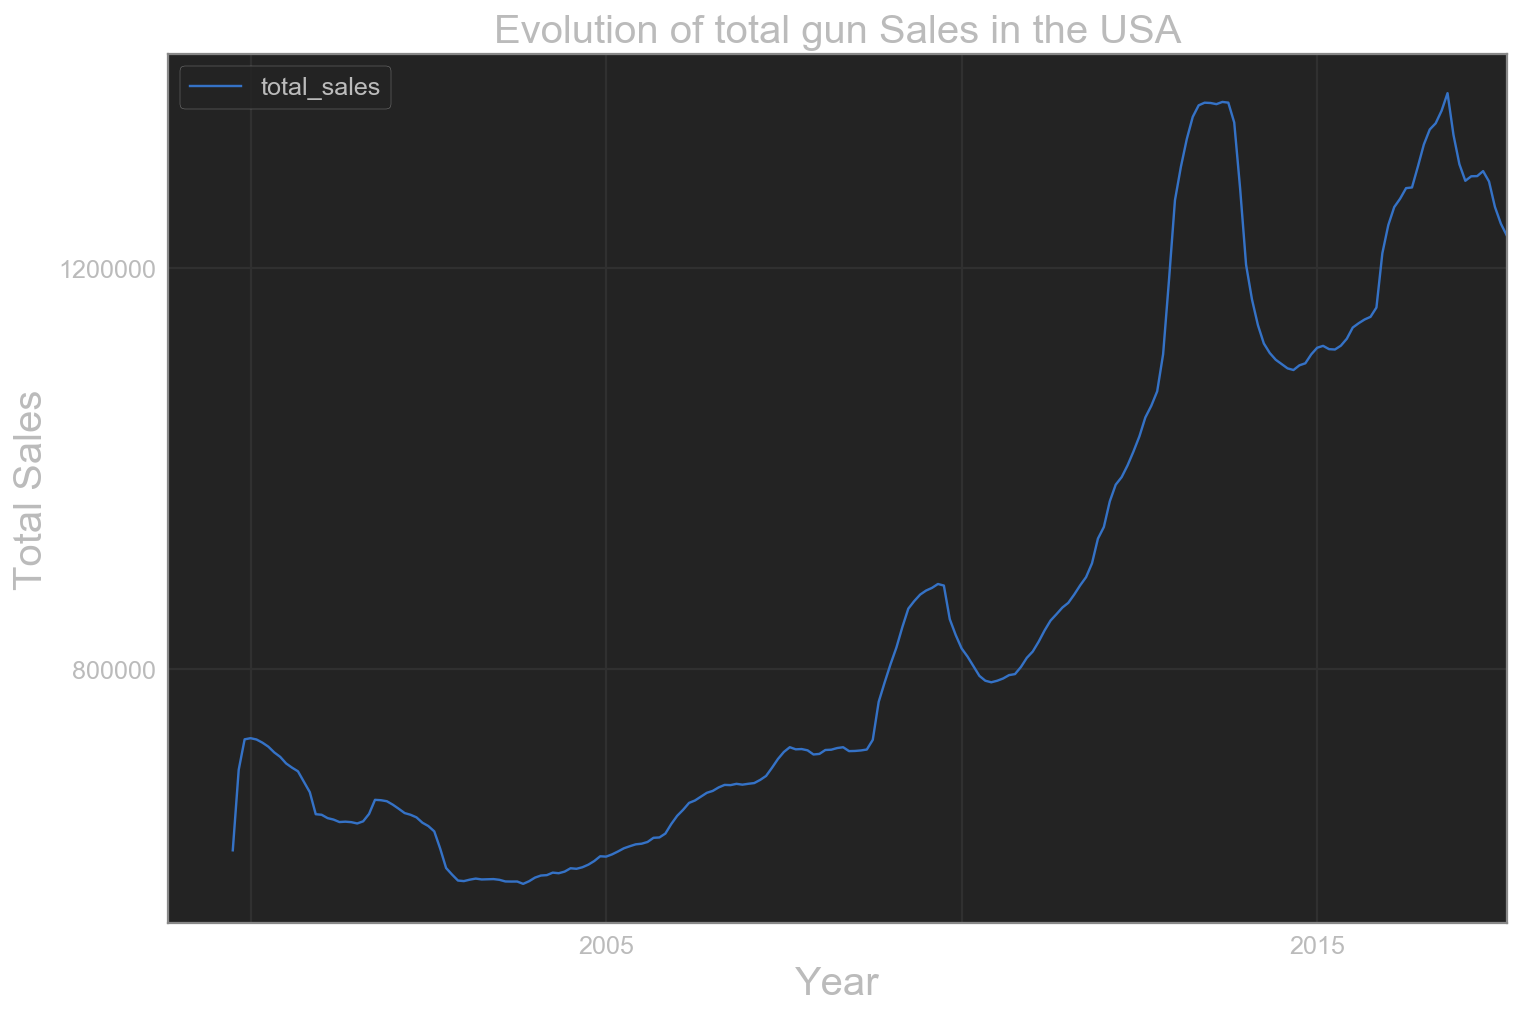

In [42]:
grouped_gun_df.plot(y='total_sales', figsize=(12, 8), yticks=[800000, 1200000], xticks=['2000', '2005', '2010', '2015'])
plt.ylabel('Total Sales', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Evolution of total gun Sales in the USA', fontsize=20);

The sales have increased strongly over the past 20 years, peaking in 2014 and 2016.
We should have a look at a sample of states to compare the evolution of gun sales more in-depth

First, let's check the lsit of states and if we have consistent data:

In [43]:
gun_df_clean.state.value_counts()

Wisconsin               227
South Carolina          227
Idaho                   227
Tennessee               227
New Mexico              227
Kansas                  227
Connecticut             227
New York                227
Texas                   227
Guam                    227
Washington              227
Alabama                 227
Maine                   227
Massachusetts           227
Wyoming                 227
Florida                 227
Virgin Islands          227
Delaware                227
Virginia                227
Maryland                227
Arizona                 227
Puerto Rico             227
Hawaii                  227
Nevada                  227
Montana                 227
South Dakota            227
Missouri                227
District of Columbia    227
Oregon                  227
New Jersey              227
California              227
Oklahoma                227
North Dakota            227
West Virginia           227
Georgia                 227
Minnesota           

Let's look into the difference in gun sales between states heavily affected by mass shooting and those who are not.
The following article is displaying the number of mass shooting per state between 1982 and 2019:
https://www.statista.com/statistics/811541/mass-shootings-in-the-us-by-state/

California has seen 19 mass shootings, Florida 11. On the other hand, Arkansas and Utah have only experienced one each.
Let's start by selecting the gun sales data related to those states:

In [44]:
gun_df_state = gun_df_clean.query('state in ["Florida", "Utah", "Arkansas", "California"]')
gun_df_state.state.unique()

array(['Arkansas', 'California', 'Florida', 'Utah'], dtype=object)

Calculating rolling average of sales per state:

In [45]:
gun_df_state = gun_df_state.groupby(['state', 'month']).sum()
gun_df_state = gun_df_state.rolling(12).mean()
gun_df_state.head(13)

handgun      long_gun    multiple  total_sales
state    month                                                         
Arkansas 1998-11-01          NaN           NaN         NaN          NaN
         1998-12-01          NaN           NaN         NaN          NaN
         1999-01-01          NaN           NaN         NaN          NaN
         1999-02-01          NaN           NaN         NaN          NaN
         1999-03-01          NaN           NaN         NaN          NaN
         1999-04-01          NaN           NaN         NaN          NaN
         1999-05-01          NaN           NaN         NaN          NaN
         1999-06-01          NaN           NaN         NaN          NaN
         1999-07-01          NaN           NaN         NaN          NaN
         1999-08-01          NaN           NaN         NaN          NaN
         1999-09-01          NaN           NaN         NaN          NaN
         1999-10-01  3817.750000   8695.833333  212.916667    14190.775
         1999-11-01  4128.416667  10287.666667  235.666667    16329.025

In [46]:
gun_df_state.reset_index(level=0, inplace=True)
gun_df_state.dropna(how='any', inplace=True)
gun_df_state.query('state in "Utah"').head()

,state,handgun,long_gun,multiple,total_sales
month,,,,,
1998-11-01,Utah,49324.333333,21753.916667,1903.916667,81993.908333
1998-12-01,Utah,44364.666667,19399.166667,1688.750000,73517.716667
1999-01-01,Utah,38714.583333,16320.500000,1479.000000,63496.591667
1999-02-01,Utah,34629.250000,14768.583333,1337.166667,57011.950000
1999-03-01,Utah,29902.416667,13098.166667,1163.916667,49628.475000


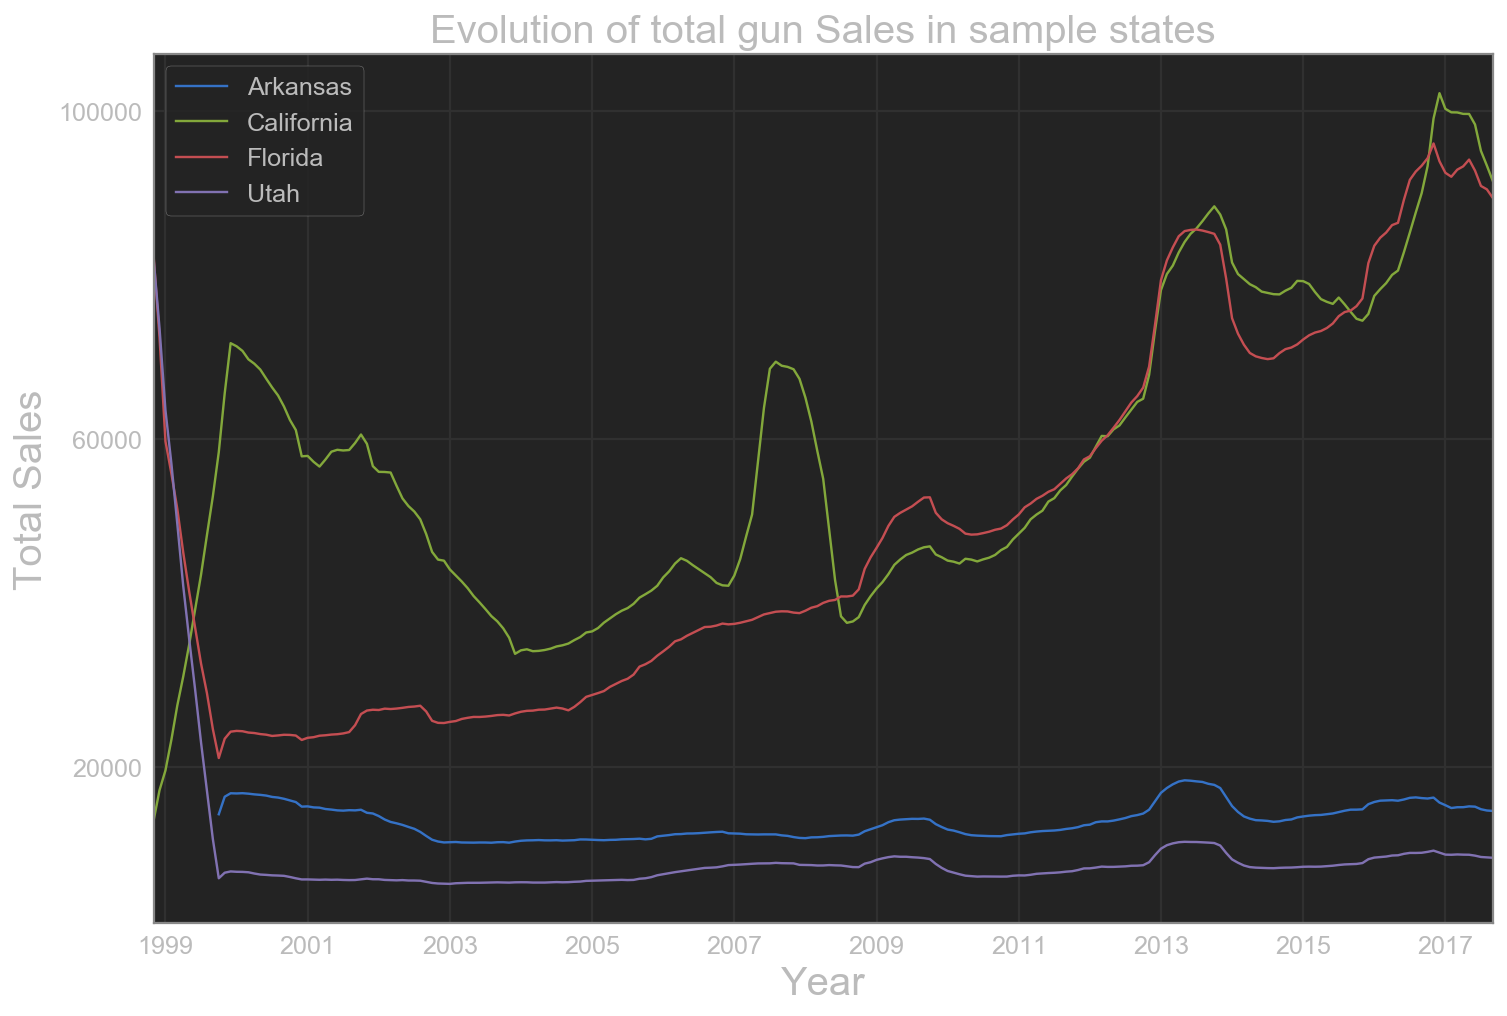

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))

gun_df_state.groupby('state')['total_sales'].plot(ax = ax, legend=True, yticks=[20000, 60000, 100000])
ax.set_title('Evolution of total gun Sales in sample states', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Total Sales', fontsize=20);

The skewed data in 1999 seems to be a one-off rather than a trend.
It is obvious that the states most affected by gun violence have evolved towards a higher quantity of guns sold; While states with a rather low level of gun violence are have kept the same level of weapon sold each month over time

To check if this trend is also true in proportion we should import the population for each state and create a per capita measure.

The population estimates calculation is detailed here: https://www2.census.gov/programs-surveys/popest/technical-documentation/methodology/2010-2018/2018-natstcopr-meth.pdf

In [48]:
pop = pd.DataFrame(census_df.iloc[:,0])
pop.reset_index(inplace=True)
pop.columns = ['state', 'pop_16']

pop.tail(5)
type(pop['pop_16'][0])

float

In [49]:
df_per_capita = pd.merge(gun_df_clean, pop, on='state', right_index=True)
print(type(df_per_capita['pop_16'][0]))
print(df_per_capita['pop_16'].str.contains(',').sum())

<class 'str'>
8626


Recently added column is a string, need to convert it to a integer (first step is to remove the comas)

In [50]:
df_per_capita['pop_16'].head()

0      4,863,300
55     4,863,300
110    4,863,300
165    4,863,300
220    4,863,300
Name: pop_16, dtype: object

In [51]:
df_per_capita['pop_16'] = df_per_capita['pop_16'].map(lambda x: x.replace(',', ''))
df_per_capita['pop_16'] = df_per_capita['pop_16'].astype(float)
df_per_capita.pop_16.head(5)

0      4863300.0
55     4863300.0
110    4863300.0
165    4863300.0
220    4863300.0
Name: pop_16, dtype: float64

In [52]:
df_per_capita['total_sales_pc'] = df_per_capita.apply(sales_per_capita, axis=1)
df_per_capita = df_per_capita[df_per_capita['month'].astype(str) == '2016-12-01']

In [53]:
gun_df_state_pc = df_per_capita.query('state in ["Florida", "Utah", "Arkansas", "California"]')
gun_df_state_pc.sort_values('total_sales_pc', ascending=False)

,month,state,handgun,long_gun,multiple,total_sales,pop_16,total_sales_pc
498,2016-12-01,Arkansas,9192.0,13433.0,385.0,25657.5,2988248.0,0.858613
504,2016-12-01,Florida,69842.0,39880.0,2595.0,125884.2,20612439.0,0.610720
542,2016-12-01,Utah,6428.0,9257.0,0.0,17253.5,3051217.0,0.565463
499,2016-12-01,California,63649.0,93224.0,0.0,172560.3,39250017.0,0.439644


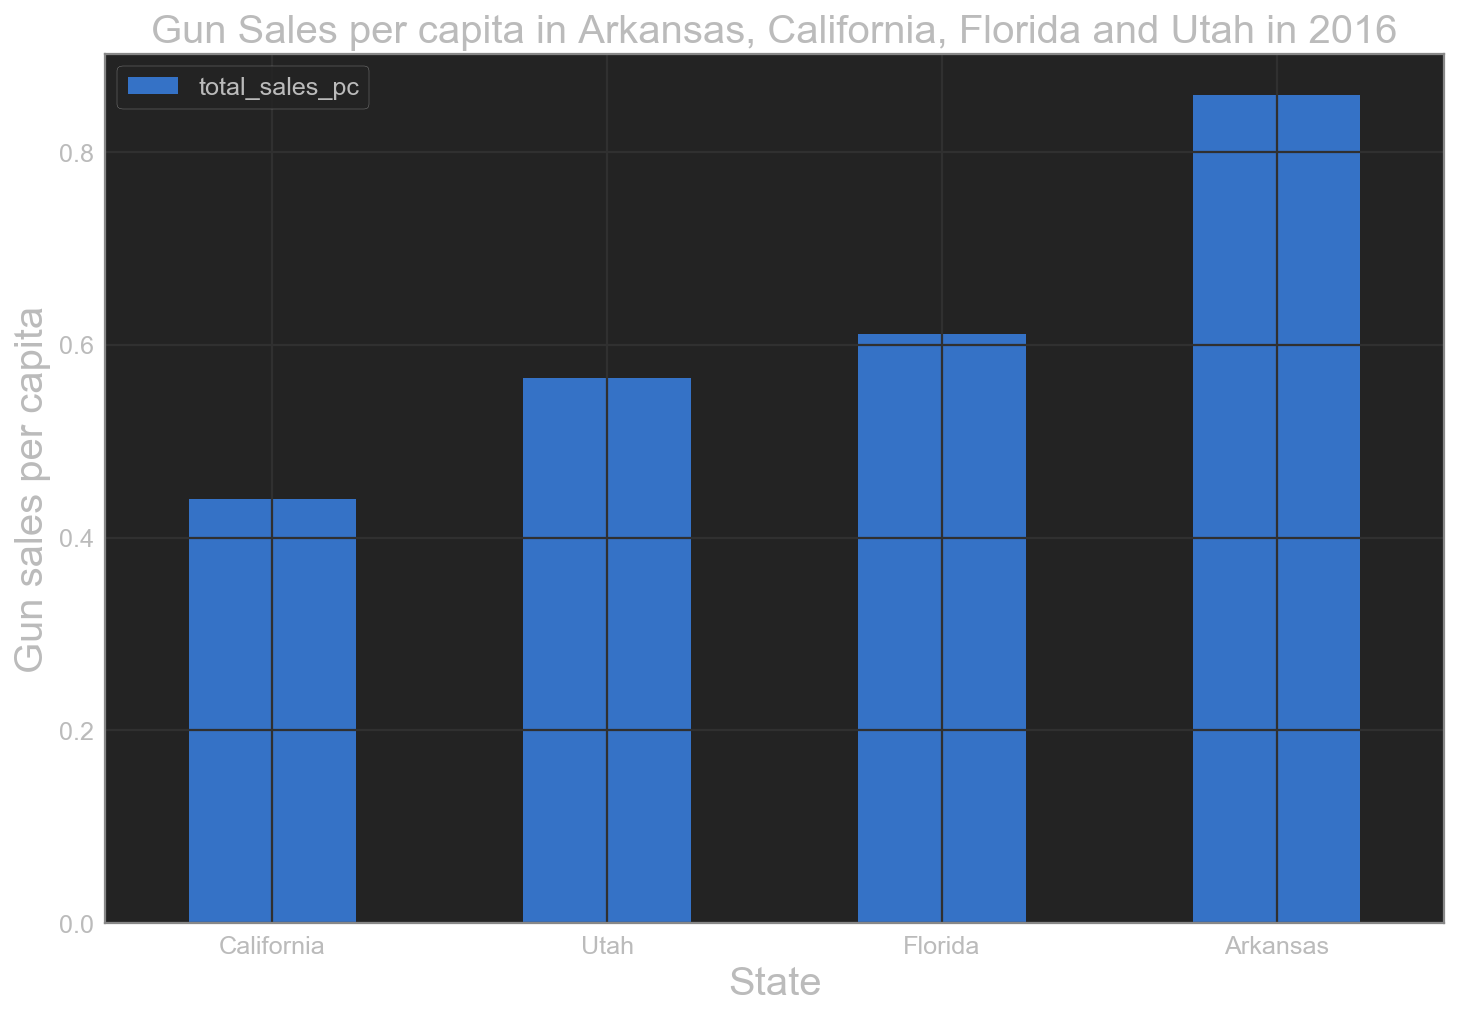

In [54]:
ax = gun_df_state_pc.sort_values('total_sales_pc').plot.bar(figsize=(12, 8), y='total_sales_pc', x='state', rot=0)
ax.set_xlabel('State', fontsize=20)
ax.set_ylabel('Gun sales per capita', fontsize=20)
plt.title('Gun Sales per capita in Arkansas, California, Florida and Utah in 2016', fontsize=20);

Looking at the 'per capita' gun sales in 2016 suggests that the states experiencing gun violence are not necessarily ahead of the one with less mass shooting.
Although this is true only for 2016 and a sample of states. On trend, the evolution of gun sales remain much stronger in states experiencing gun violence.

### Research Question 2: Which are the social features correlated with gun ownership in 2016?

We aim at identify features associatedd with high and low rates of gun sales per capita in 2016.
To do so we need to identify which states are among the top and bottom of the list. To make the gun sales comparable with the social features, we need to use the sales per capita.

First, let's merge together the gun sales data and the selected social features for 2016:

In [55]:
gun_df_clean.head()

,month,state,handgun,long_gun,multiple,total_sales
0,2017-09-01,Alabama,5734.0,6320.0,317.0,13893.4
1,2017-09-01,Alaska,2320.0,2930.0,160.0,6095.0
2,2017-09-01,Arizona,11063.0,7946.0,631.0,22171.9
3,2017-09-01,Arkansas,4347.0,6063.0,366.0,12183.0
4,2017-09-01,California,37165.0,24581.0,0.0,67920.6


In [56]:
social_df.head(5)

,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment
Alabama,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0
Alaska,741894.0,10.4,47.7,3.8,7.3,69323.0,1146.0,2.81,28.0,8.1,9.9,267999.0
Arizona,6931071.0,16.9,50.3,4.9,2.8,505794.0,913.0,2.69,27.5,8.2,16.4,2295186.0
Arkansas,2988248.0,16.3,50.9,15.7,2.0,220953.0,677.0,2.53,21.1,12.3,17.2,1003113.0
California,39250017.0,13.6,50.3,6.5,3.8,1777410.0,1255.0,2.96,31.4,6.8,14.3,14325377.0


In [57]:
social_df.reset_index(inplace=True)
social_df.rename(columns= {'index' : 'state'}, inplace=True)
df_gun_feat = pd.merge(gun_df_clean, social_df, on='state', right_index=True)
df_gun_feat.head()

C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,month,state,handgun,long_gun,multiple,total_sales,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment
0,2017-09-01,Alabama,5734.0,6320.0,317.0,13893.4,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0
55,2017-08-01,Alabama,6289.0,6045.0,311.0,14189.4,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0
110,2017-07-01,Alabama,6046.0,4790.0,258.0,12435.6,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0
165,2017-06-01,Alabama,8275.0,4782.0,334.0,15030.7,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0
220,2017-05-01,Alabama,7198.0,4559.0,309.0,13550.7,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0


Filtering for 2016 data and checking we have the 50 American states:

In [58]:
df_gun_feat_16 = df_gun_feat[df_gun_feat['month'].astype(str) == '2016-12-01']
df_gun_feat_16.shape

(50, 18)

Applying functions to calculate employment rate and sales per capita:

In [59]:
df_gun_feat_16['total_sales_pc'] = df_gun_feat_16.apply(sales_per_capita, axis=1)
df_gun_feat_16['empl_rate'] = df_gun_feat_16.apply(employment_rate, axis=1)
df_gun_feat_16.head(5)

C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,month,state,handgun,long_gun,multiple,total_sales,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment,total_sales_pc,empl_rate
495,2016-12-01,Alabama,13733.0,17519.0,533.0,35443.2,4863300.0,16.1,51.6,26.8,1.6,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0,0.728789,33.606625
496,2016-12-01,Alaska,4087.0,3698.0,191.0,8945.5,741894.0,10.4,47.7,3.8,7.3,69323.0,1146.0,2.81,28.0,8.1,9.9,267999.0,1.205765,36.123624
497,2016-12-01,Arizona,18024.0,13785.0,703.0,36395.9,6931071.0,16.9,50.3,4.9,2.8,505794.0,913.0,2.69,27.5,8.2,16.4,2295186.0,0.525112,33.114449
498,2016-12-01,Arkansas,9192.0,13433.0,385.0,25657.5,2988248.0,16.3,50.9,15.7,2.0,220953.0,677.0,2.53,21.1,12.3,17.2,1003113.0,0.858613,33.568599
499,2016-12-01,California,63649.0,93224.0,0.0,172560.3,39250017.0,13.6,50.3,6.5,3.8,1777410.0,1255.0,2.96,31.4,6.8,14.3,14325377.0,0.439644,36.497760


Let's have a look at the distribution of sales per capita to check if everything looks consistent:

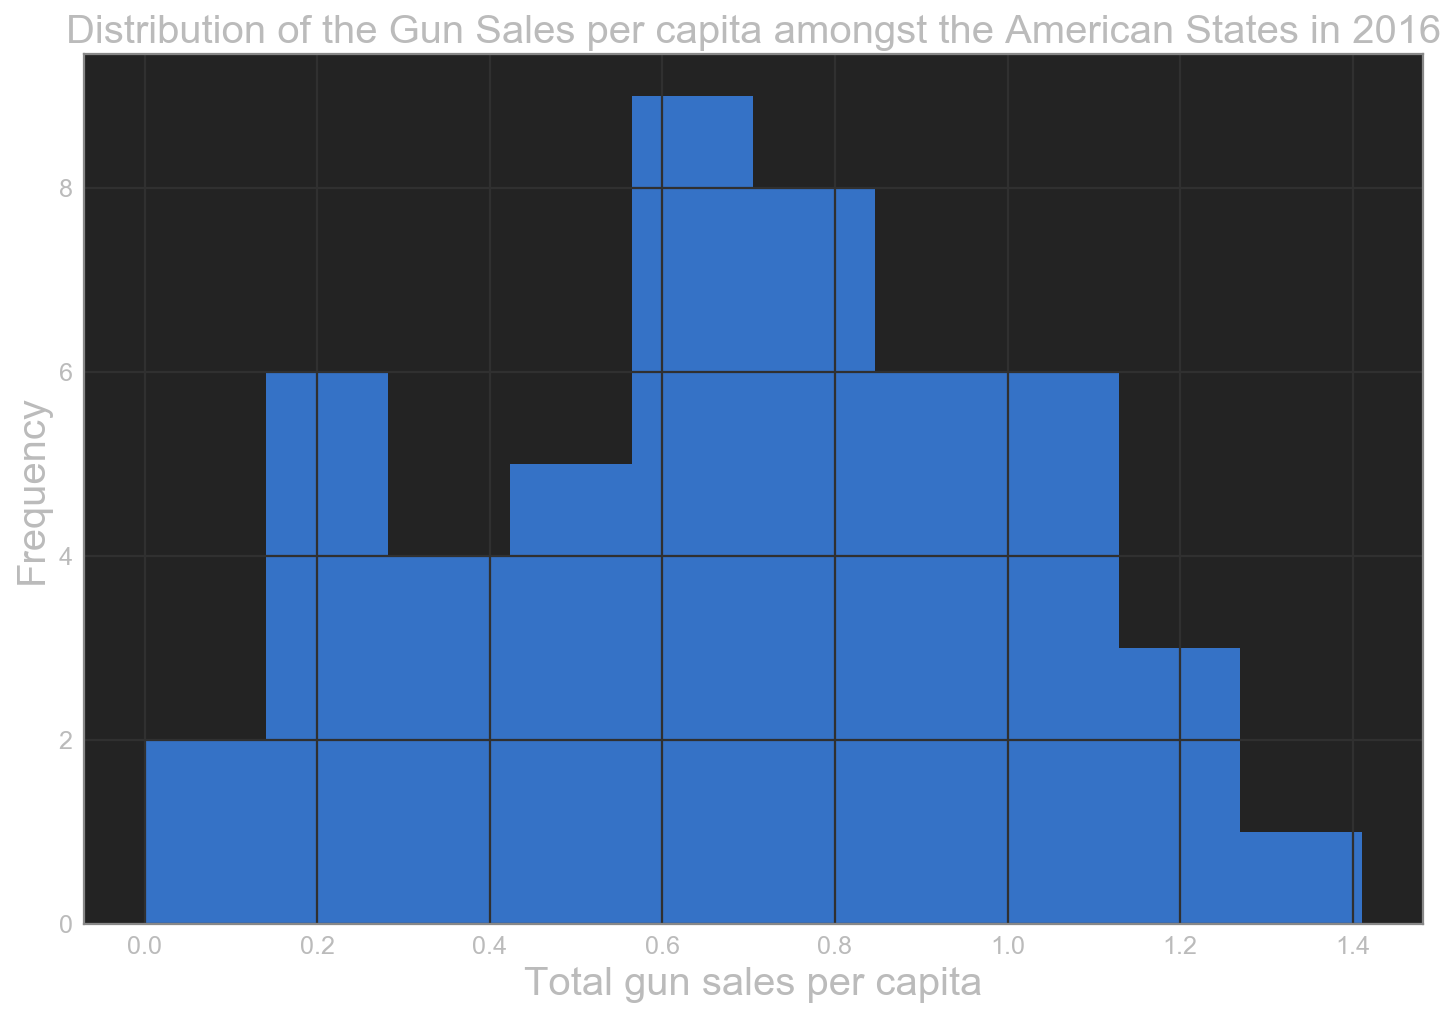

In [60]:
df_gun_feat_16.hist('total_sales_pc', figsize=(12, 8))
plt.xlabel('Total gun sales per capita', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of the Gun Sales per capita amongst the American States in 2016', fontsize=20);

This is a normal distribution. Let's have a look at the descriptive statistics; More specifically, we will pay attention to the sales per capita quartiles:

In [61]:
df_gun_feat_16.describe()

,handgun,long_gun,multiple,total_sales,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment,total_sales_pc,empl_rate
count,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.00000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.00000,5.000000e+01,50.000000,50.000000
mean,16869.040000,15903.120000,470.100000,36989.576000,6.448927e+06,11.81044,38.511740,8.360900,2.310400,4.015940e+05,879.880000,2.582000,22.363160,6.812720,10.05498,2.471459e+06,0.679205,38.486424
std,18018.300871,16534.355843,642.415571,37076.828874,7.271769e+06,6.84738,21.584467,9.917937,3.389157,3.831585e+05,181.106761,0.164105,13.383697,4.172118,6.26358,2.733595e+06,0.328645,4.166900
min,0.000000,0.000000,0.000000,0.000000,5.855010e+05,0.14500,0.487000,0.020000,0.018000,4.470800e+04,643.000000,2.320000,0.241000,0.068000,0.10700,2.198810e+05,0.000000,30.095122
25%,4712.000000,4740.250000,34.000000,11541.975000,1.850106e+06,10.42500,48.000000,0.650000,1.300000,1.332715e+05,743.500000,2.482500,19.575000,6.525000,7.80000,5.888890e+05,0.444092,36.011755
50%,11471.500000,13609.000000,232.500000,30639.950000,4.559320e+06,15.00000,50.300000,4.700000,2.000000,3.020175e+05,818.500000,2.550000,27.200000,8.000000,11.35000,1.606934e+06,0.694149,37.715005
75%,21109.000000,20705.000000,640.500000,46281.725000,7.198768e+06,16.10000,50.900000,12.400000,2.475000,4.949490e+05,1001.500000,2.637500,31.075000,9.000000,14.25000,3.040622e+06,0.892910,40.908063
max,69842.000000,93224.000000,3208.000000,172560.300000,3.925002e+07,19.90000,51.600000,37.700000,23.700000,1.777410e+06,1438.000000,3.150000,40.500000,14.400000,20.80000,1.432538e+07,1.410773,48.273901


Now that we have identified the quartiles values, we can cut the dataframe and rate the different states depending om whether they have been buying an important amount of guns in proportion of the state's population or not:

In [62]:
bin_edges = [ 0, 0.444092, 0.694149, 0.892910, 1.410773]
bin_names = [ 'Low', 'Medium', 'Moderate', 'High']
df_gun_feat_16['gun_rate'] = pd.cut(df_gun_feat_16['total_sales_pc'], bin_edges, labels=bin_names)
df_gun_feat_16.head(5)

C:\Users\afunel1\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,month,state,handgun,long_gun,multiple,total_sales,pop_16,pop_over_65,female_pop,black_pop,...,vet,med_rent,per_houshold,edu,disabled,poverty,employment,total_sales_pc,empl_rate,gun_rate
495,2016-12-01,Alabama,13733.0,17519.0,533.0,35443.2,4863300.0,16.1,51.6,26.8,...,363170.0,717.0,2.55,23.5,11.8,17.1,1634391.0,0.728789,33.606625,Moderate
496,2016-12-01,Alaska,4087.0,3698.0,191.0,8945.5,741894.0,10.4,47.7,3.8,...,69323.0,1146.0,2.81,28.0,8.1,9.9,267999.0,1.205765,36.123624,High
497,2016-12-01,Arizona,18024.0,13785.0,703.0,36395.9,6931071.0,16.9,50.3,4.9,...,505794.0,913.0,2.69,27.5,8.2,16.4,2295186.0,0.525112,33.114449,Medium
498,2016-12-01,Arkansas,9192.0,13433.0,385.0,25657.5,2988248.0,16.3,50.9,15.7,...,220953.0,677.0,2.53,21.1,12.3,17.2,1003113.0,0.858613,33.568599,Moderate
499,2016-12-01,California,63649.0,93224.0,0.0,172560.3,39250017.0,13.6,50.3,6.5,...,1777410.0,1255.0,2.96,31.4,6.8,14.3,14325377.0,0.439644,36.497760,Low


In [63]:
df_gun_feat_16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 495 to 549
Data columns (total 21 columns):
month             50 non-null datetime64[ns]
state             50 non-null object
handgun           50 non-null float64
long_gun          50 non-null float64
multiple          50 non-null float64
total_sales       50 non-null float64
pop_16            50 non-null float64
pop_over_65       50 non-null float64
female_pop        50 non-null float64
black_pop         50 non-null float64
two_more_race     50 non-null float64
vet               50 non-null float64
med_rent          50 non-null float64
per_houshold      50 non-null float64
edu               50 non-null float64
disabled          50 non-null float64
poverty           50 non-null float64
employment        50 non-null float64
total_sales_pc    50 non-null float64
empl_rate         50 non-null float64
gun_rate          48 non-null category
dtypes: category(1), datetime64[ns](1), float64(18), object(1)
memory usage: 8.4+ KB


Next step is to find out what are the features associated with each level of gun purchase:

In [64]:
mean_df = df_gun_feat_16.groupby('gun_rate').mean()
mean_df

,handgun,long_gun,multiple,total_sales,pop_16,pop_over_65,female_pop,black_pop,two_more_race,vet,med_rent,per_houshold,edu,disabled,poverty,employment,total_sales_pc,empl_rate
gun_rate,,,,,,,,,,,,,,,,,,
Low,12478.083333,17140.166667,188.166667,32956.408333,1.027661e+07,11.506167,38.295167,9.223333,1.806167,529951.750000,985.083333,2.594167,25.028750,5.696583,8.852417,4.020900e+06,0.275538,40.605872
Medium,22082.750000,18636.250000,795.500000,46381.900000,8.069349e+06,14.097250,46.326250,9.864583,2.418167,530211.666667,906.416667,2.646667,27.163167,7.666917,11.954417,3.031962e+06,0.585249,38.795971
Moderate,19680.083333,14807.500000,438.083333,38812.508333,5.041072e+06,10.637167,33.984333,7.425000,1.457250,362022.416667,771.916667,2.520833,17.857250,7.021917,9.790000,1.944351e+06,0.787632,37.701697
High,15141.000000,14710.083333,491.750000,33819.691667,3.211860e+06,9.977917,33.501500,7.840833,1.828417,229434.250000,829.333333,2.542500,18.964000,6.259250,9.032250,1.209773e+06,1.064040,37.628454


This is very interesting, it seems that some features like the female population are not correlated while some others are, like the education level (consistently decreasing from low to high gun sales category).

The final step is to plot our most interesting findings:

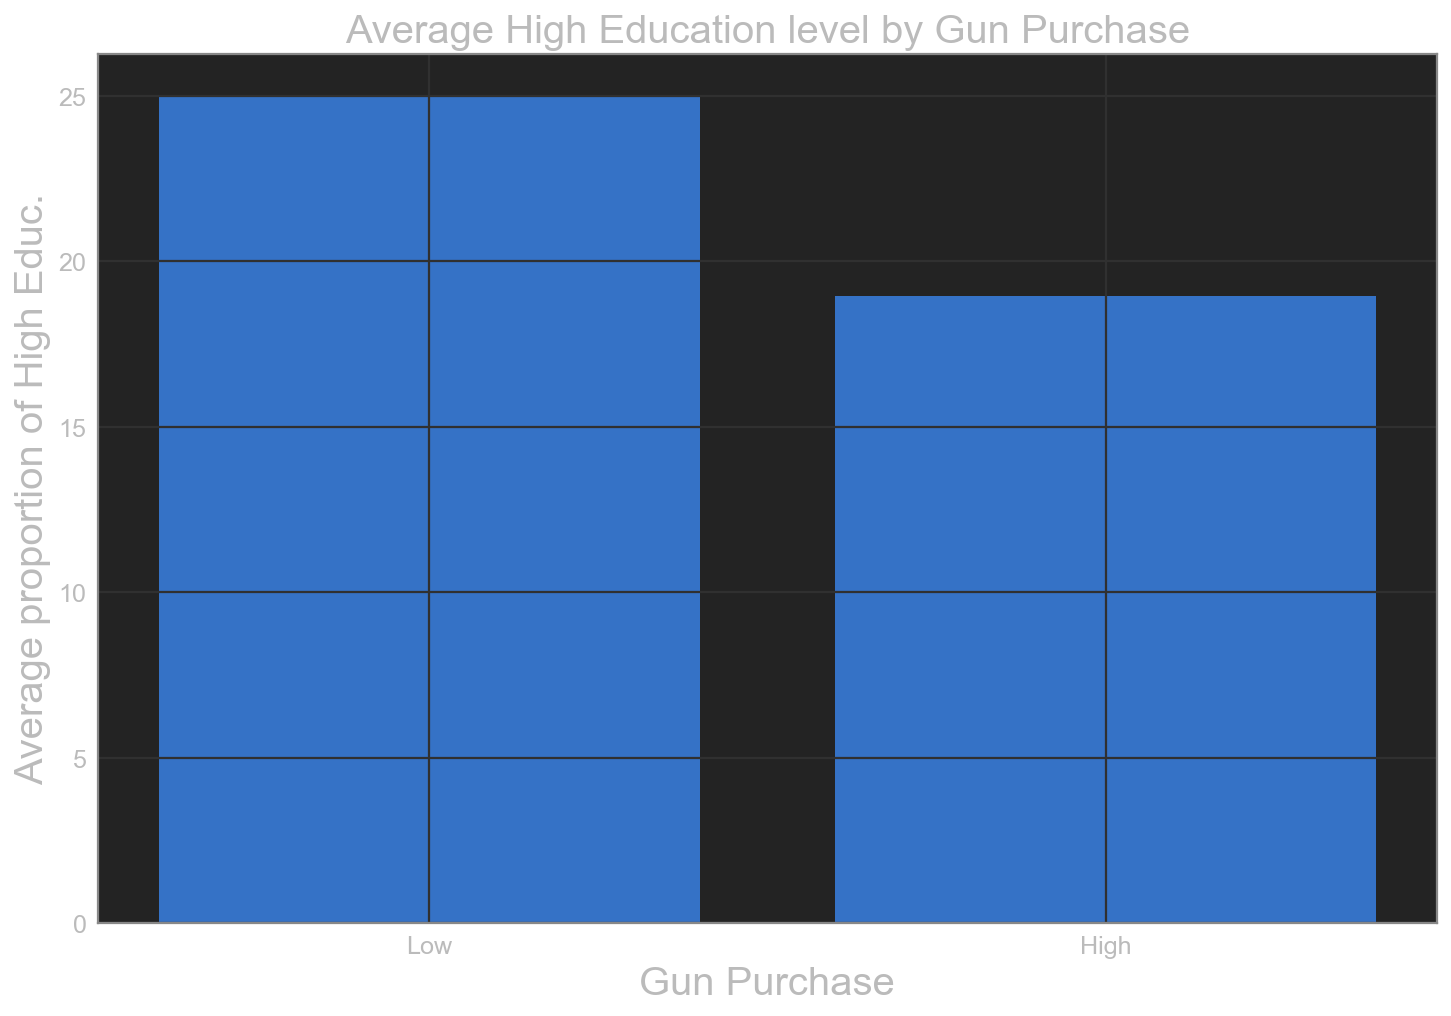

In [65]:
mean_edu_low = mean_df.iloc[0,12]
mean_edu_high = mean_df.iloc[3,12]

locations = [1, 2]
heights = [mean_edu_low, mean_edu_high]
labels = ['Low', 'High']
plt.figure(figsize=(12, 8))
plt.bar(locations, heights, tick_label=labels)
plt.title('Average High Education level by Gun Purchase', fontsize=20)
plt.xlabel('Gun Purchase', fontsize=20)
plt.ylabel('Average proportion of High Educ.', fontsize=20);

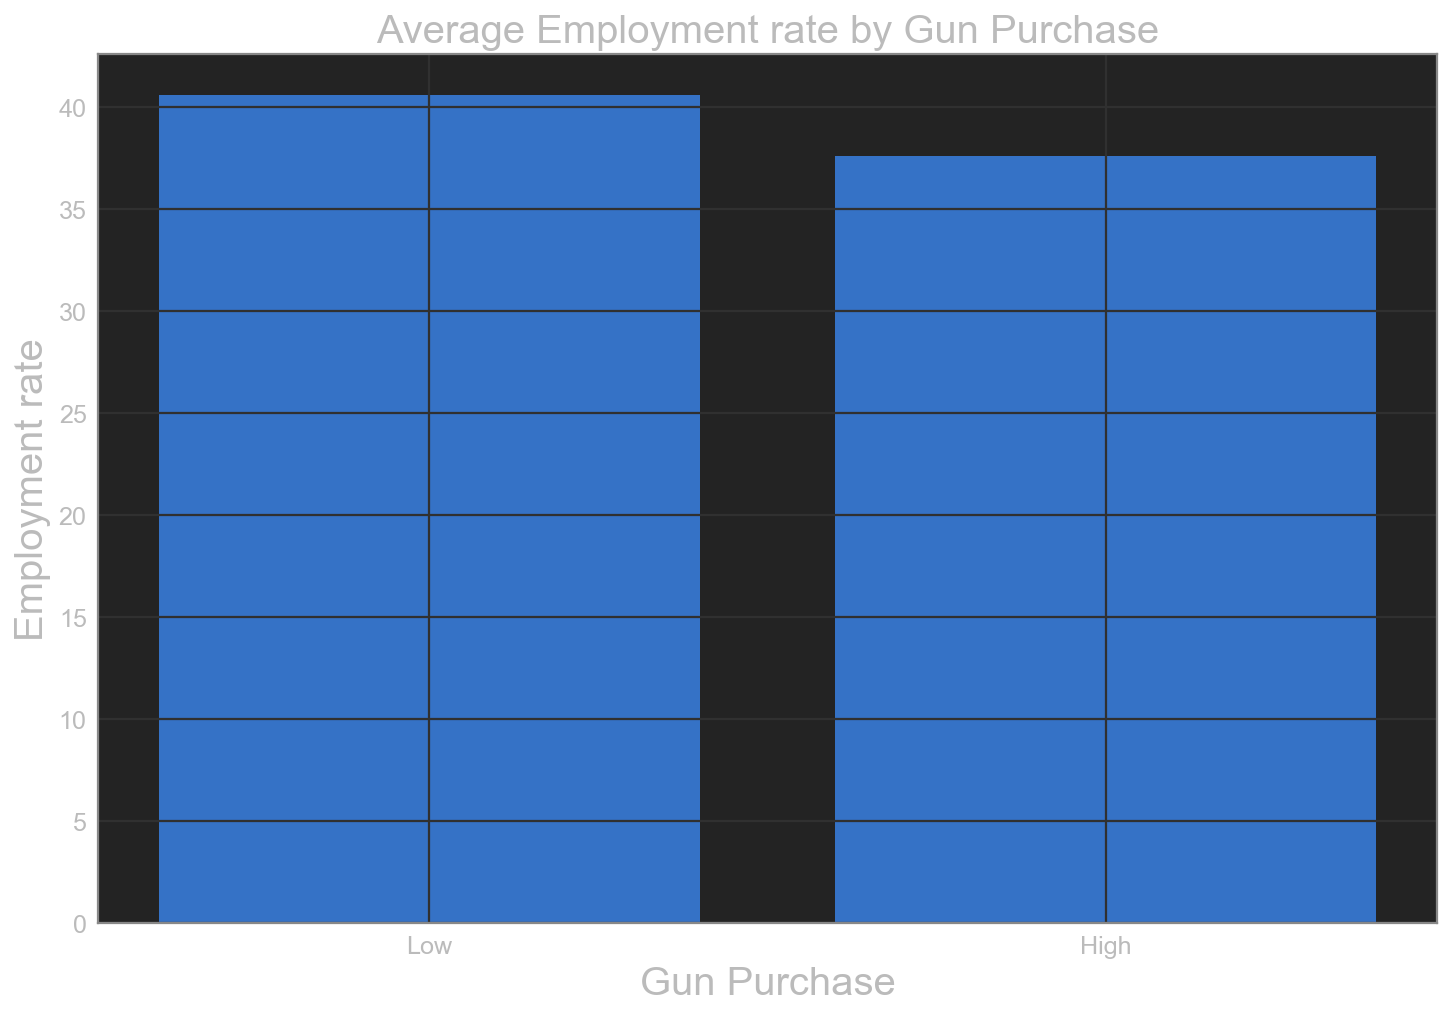

In [66]:
mean_empl_low = mean_df.iloc[0,-1]
mean_empl_high = mean_df.iloc[3,-1]

locations = [1, 2]
heights = [mean_empl_low, mean_empl_high]
labels = ['Low', 'High']
plt.figure(figsize=(12, 8))
plt.bar(locations, heights, tick_label=labels)
plt.title('Average Employment rate by Gun Purchase', fontsize=20)
plt.xlabel('Gun Purchase', fontsize=20)
plt.ylabel('Employment rate', fontsize=20);

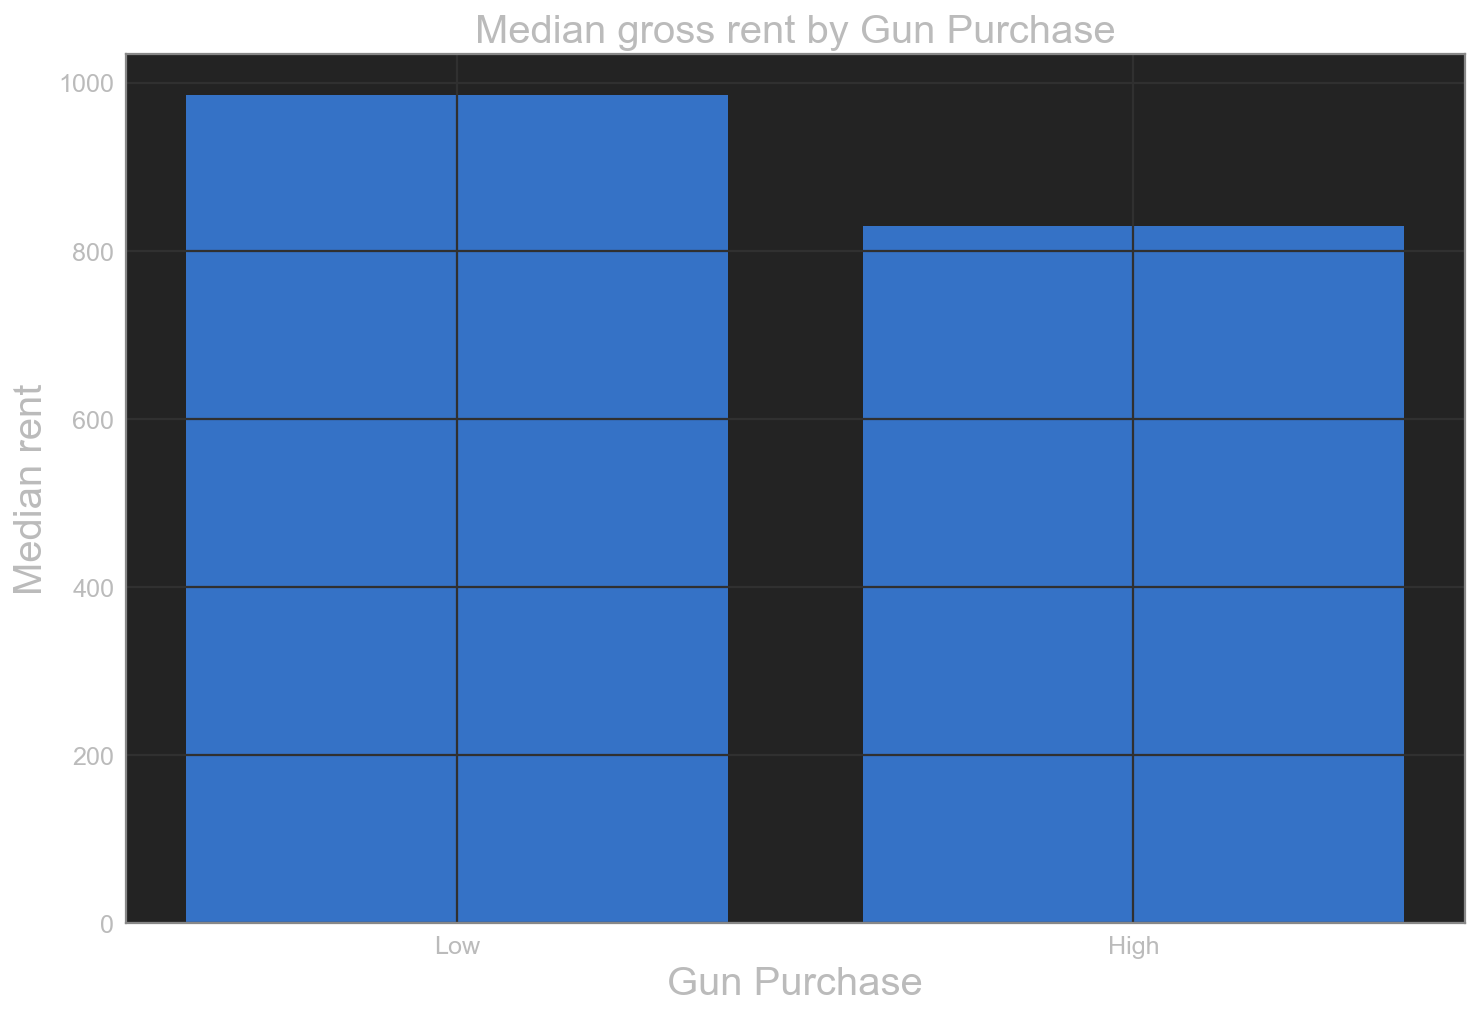

In [67]:
mean_rent_low = mean_df.iloc[0,10]
mean_rent_high = mean_df.iloc[3,10]

locations = [1, 2]
heights = [mean_rent_low, mean_rent_high]
labels = ['Low', 'High']
plt.figure(figsize=(12, 8))
plt.bar(locations, heights, tick_label=labels)
plt.title('Median gross rent by Gun Purchase', fontsize=20)
plt.xlabel('Gun Purchase', fontsize=20)
plt.ylabel('Median rent', fontsize=20);

Study of 2016 data suggests that a low proportion of gun purchase is associated with higher education level, higher employment rate and higher median rent. It is also relevant to mention that other features we have studied have not demonstrated a correlation in 2016, like the proportion of Black/African American alone or the proportion of veterans.

To go further we could investigate the variation of gun sales per capita to investigate if the correlations exist over time.

<a id='limitations'></a>
## Limitations

Although the aboce study is insightful about the gun sales trends and the features associated with it, it is important to underline some limitations associated with the data we have investigated:
- The 2016 population is an estimate based on the 2010 census. Although it may be close to the reality, it is a statistical estimatioon and may differ.
- The gun sales are an estimation based on the method suggested Georgia Regents University's Professor Jurgen Brauer. Thus, it is not an exact representation of the gun sales. Moreover, this dataset is considering the background checks registered in gun shops and does not encompass the private gun sales. Therefore, the actual number of gun sales may differ from the estimation based on the data provided by the FBI.
- To be able to plot the gun sales we have had to fill some NaN values with the data from the previous month. Althought this was quite limited, it may alter the loyal representation of point-in-time data.
- The study of the relationship between gun sales per capita and social measures in 2016 is insightful but is not enough to reveal a stong correlation. Historical data from the Census Bureau should be added to investigate those relationships over time and find strong correlations.

<a id='conclusions'></a>
## Conclusions

The number of gun sales (derivated from the sum of the number of background checks per state in America) has increased significantly from 1999 to nowadays. In absolute number (i.e with no regards of the population growth) the number of sales have significantly increased in the states with the strongest occurence of mass shooting, and kept the same level in the states less exposed to gun violence.
In 2016, a correlation existed between gun sales per capita a various social features. The states with the lowest level of gun sales per capita had a higher level of educated population, a highest employment rate and a higher median rent.